In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt
from cleaning_function import *

tf.config.threading.set_intra_op_parallelism_threads(64)
tf.config.threading.set_inter_op_parallelism_threads(64)

# Load the data
X = pd.read_csv('alaska_predict.csv')
X = exclude_columns(X, ['black', 'NHPI','asian','white','hispanic','single_race','aian'])
y = pd.read_csv('alaska_response.csv')

# Replace missing values in y with NaN
y = y.replace("?", np.nan)  # If missing values are marked with "?" in the dataset
y_numeric = y.select_dtypes(include="number")  # Remove 'statecounty'

# Normalize X (remove the 'statecounty' column)
X_numeric = X.select_dtypes(include='number')  # Remove 'statecounty'
X_numeric.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_numeric, test_size=0.2)

In [20]:
#y_train = y_train.fillna(y_train.mean())

In [21]:
X

,Healthcare_General_Practice_Provider_Rate_per100000_HRSA2020,Healthcare_Family_Medicine_Provider_Rate_per100000_HRSA2020,Civilian_Noninstitutionalized_Population_For_Insurance_Coverage_ACS2016_20,Population_With_Health_Insurance_ACS2016_20,Population_Without_Health_Insurance_ACS2016_20,Percent_Population_Without_Health_Insurance_ACS2016_20,Population_18yrs_And_Under_Civilian_Noninstitutionalized_Population_For_Insurance_Coverage_ACS2016_20,Population_18yrs_And_Under_With_Health_Insurance_ACS2016_20,Population_18yrs_And_Under_Without_Health_Insurance_ACS2016_20,PercentPopulation_18yrs_And_Under_Without_Health_Insurance_ACS2016_20,...,Percent_of_Farmers_Market_Accept_SNAP_USDA_2018,Number_of_Farmers_Market_Accept_WIC_USDA_2018,Percent_of_Farmers_Market_Accept_WIC_USDA_2018,Number_of_Farmers_Market_Accept_WIC_Cash_USDA_2018,Percent_of_Farmers_Market_Accept_SNAP_USDA_2018.1,Number_of_Farmers_Market_Accept_SFMNP_USDA_2018,Percent_of_Farmers_Market_Accept_SFMNP_USDA_2018,Number_of_Recreation_Fitness_Facilities_Per1000_Residents_USDA_2016,statecounty,state_number
0,0.000000,-1.044776,-0.390549,-0.404925,-0.187878,4.976153,-0.413699,-0.410374,-0.232698,5.423559,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,-0.333333,02Aleutians East Borough,2
1,0.000000,0.268657,-0.353467,-0.356576,-0.272206,1.392687,-0.365357,-0.358349,-0.264794,1.261153,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,-0.333333,02Aleutians West Census Area,2
2,1.842105,1.865672,4.592260,4.463398,5.668579,0.340223,5.058215,4.844870,7.110665,0.571429,...,1.5,6.0,3.447887,5.0,1.5,6.0,1.800000,7.000000,02Anchorage Municipality,2
3,0.000000,2.194030,-0.127628,-0.153859,0.182504,1.427663,0.058420,0.045194,0.363758,0.789975,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,-0.166667,02Bethel Census Area,2
4,0.000000,-1.044776,-0.438390,-0.432947,-0.441689,1.222576,-0.437201,-0.424731,-0.406553,1.377444,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,-0.333333,02Bristol Bay Borough,2
5,0.000000,0.358209,-0.337400,-0.339206,-0.270966,1.022258,-0.338360,-0.340904,-0.081578,2.578446,...,0.6,0.1,0.574648,0.2,0.6,0.0,0.000000,-0.233333,02Chugach Census Area,2
6,0.000000,2.947761,-0.399635,-0.399716,-0.347233,1.826709,-0.387892,-0.384516,-0.216650,2.983459,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,02Copper River Census Area,2
7,0.000000,-1.044776,-0.407659,-0.403378,-0.400765,0.715421,-0.427905,-0.414079,-0.423938,-0.659649,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,-0.333333,02Denali Borough,2
8,10.894737,7.447761,-0.363003,-0.366622,-0.275720,1.632750,-0.327650,-0.322688,-0.204614,1.124812,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,-0.333333,02Dillingham Census Area,2
9,1.631579,1.022388,1.187245,1.171615,1.297163,0.146264,1.403529,1.357326,1.817452,0.396992,...,2.0,3.0,5.746479,0.0,2.0,1.0,1.000000,1.666667,02Fairbanks North Star Borough,2


In [22]:
print(X_train.isnull().sum())
print(X_train.isin([np.inf, -np.inf]).sum())
print(y_train.isnull().sum())


Healthcare_General_Practice_Provider_Rate_per100000_HRSA2020                  0
Healthcare_Family_Medicine_Provider_Rate_per100000_HRSA2020                   0
Civilian_Noninstitutionalized_Population_For_Insurance_Coverage_ACS2016_20    0
Population_With_Health_Insurance_ACS2016_20                                   0
Population_Without_Health_Insurance_ACS2016_20                                0
                                                                             ..
Percent_of_Farmers_Market_Accept_SNAP_USDA_2018.1                             0
Number_of_Farmers_Market_Accept_SFMNP_USDA_2018                               0
Percent_of_Farmers_Market_Accept_SFMNP_USDA_2018                              0
Number_of_Recreation_Fitness_Facilities_Per1000_Residents_USDA_2016           0
state_number                                                                  0
Length: 214, dtype: int64
Healthcare_General_Practice_Provider_Rate_per100000_HRSA2020                  0
Healthcare_Fam

In [23]:
def masked_loss(y_true, y_pred):
    mask = tf.math.is_finite(y_true)  # Create a mask to ignore NaNs
    diff = tf.boolean_mask(y_true - y_pred, mask)  # Ignore NaNs
    return tf.reduce_mean(tf.square(diff))

def build_model(hp):
    model = tf.keras.models.Sequential()
    input_dim = X_train.shape[1]  # Ensure correct input dimension
    model.add(tf.keras.layers.InputLayer(input_shape=(input_dim,)))

    # Tune number of layers and units
    for i in range(hp.Int('num_layers', 2, 3)):  # Between 2 and 3 layers
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                     min_value=128,
                                                     max_value=256,  # Adjust range
                                                     step=64),
                                        activation='relu'))
        model.add(tf.keras.layers.Dropout(hp.Float('dropout_' + str(i),
                                                   min_value=0.2,
                                                   max_value=0.4,
                                                   step=0.1)))

    # Output layer matching y_train shape
    output_dim = y_train.shape[1] if len(y_train.shape) > 1 else 1
    model.add(tf.keras.layers.Dense(output_dim, activation='linear'))

    # Compile model with masked loss
    model.compile(optimizer=tf.keras.optimizers.Adam(
                      hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')),
                  loss=masked_loss,
                  metrics=['mae'])
    return model

# Hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='multi_target_hyperparam_tuning',
    max_consecutive_failed_trials=10
)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [24]:
# tuner.results_summary()


In [25]:

# shap graph starts
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=64, verbose = 1)

best_model = tuner.get_best_models(num_models=1)[0]
loss, mae = best_model.evaluate(X_test, y_test)
print(f"Best Model Test Loss: {loss}, Test MAE: {mae}")

best_model.save('best_multi_target_model.h5')

Trial 20 Complete [00h 00m 09s]
val_mae: 167.9668197631836

Best val_mae So Far: 50.85093688964844
Total elapsed time: 00h 02m 49s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 16591.1582 - mae: 77.0351


Best Model Test Loss: 16591.158203125, Test MAE: 77.03510284423828


In [26]:
from tensorflow.keras.models import load_model
import shap
import matplotlib.pyplot as plt

# Load the saved model
best_model = load_model('best_multi_target_model.h5', compile=False)
assert list(X_train.columns) == list(X_test.columns), "Mismatch in feature columns"


In [37]:
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred
residuals

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


,response
3,10.885264
26,14.256732
22,-11.117915
16,-301.916650
18,73.324350
25,-50.709686


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


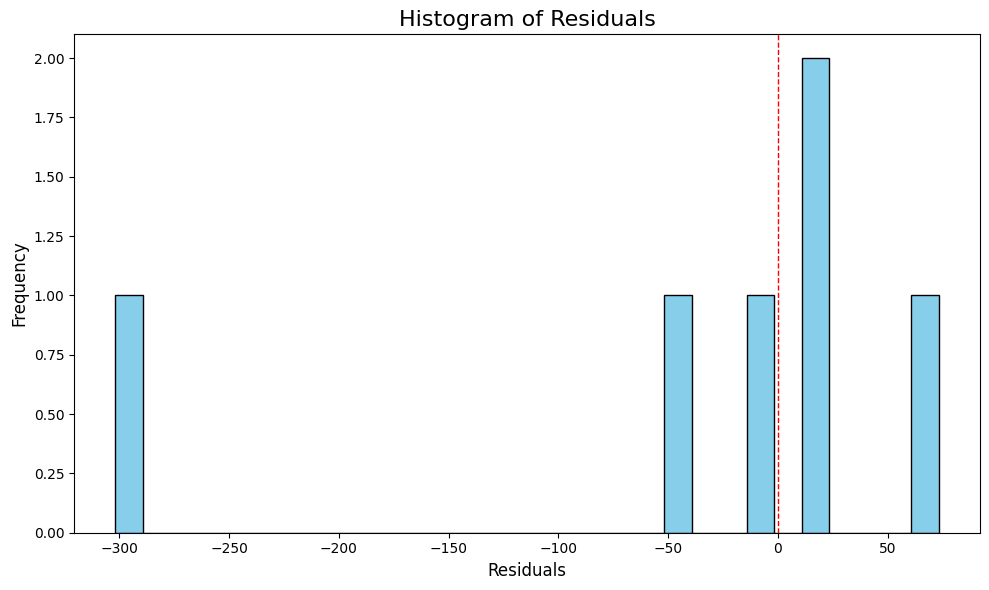

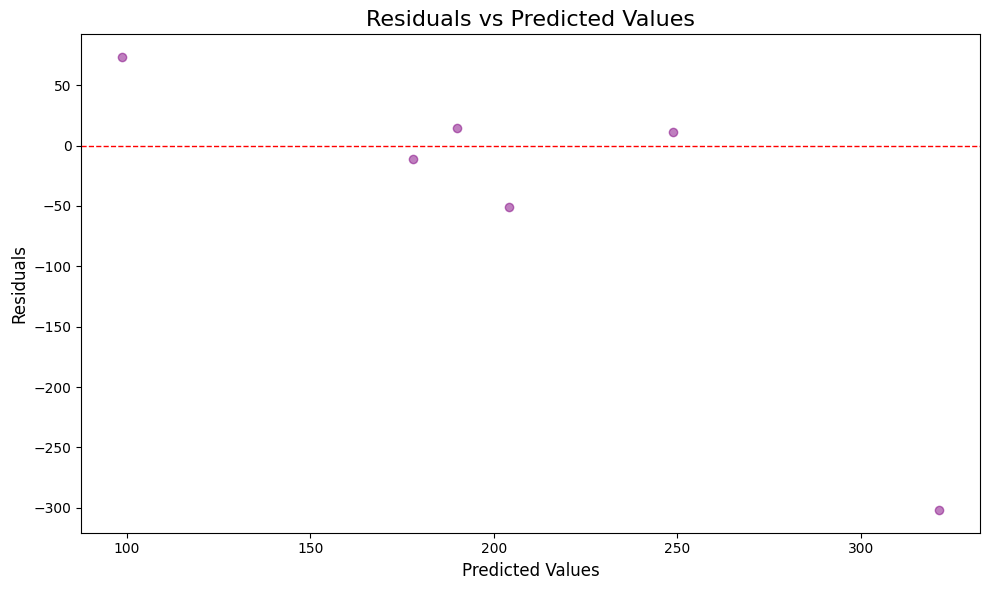

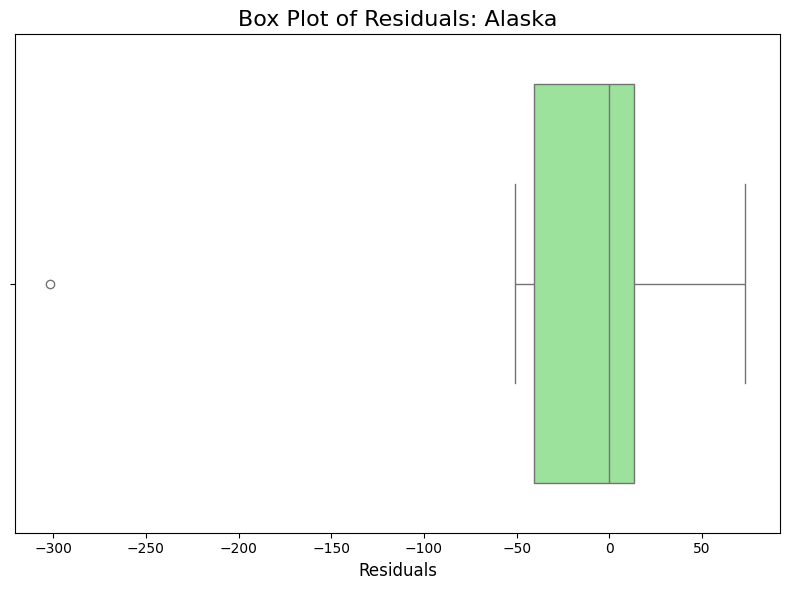

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = best_model.predict(X_test)
residuals = y_test - y_pred
residuals = np.array(residuals).flatten()

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
plt.title("Histogram of Residuals", fontsize=16)
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='purple')
plt.axhline(0, color='red', linestyle='dashed', linewidth=1)
plt.title("Residuals vs Predicted Values", fontsize=16)
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x=residuals, color='lightgreen')
plt.title("Box Plot of Residuals: Alaska", fontsize=16)
plt.xlabel("Residuals", fontsize=12)
plt.tight_layout()
plt.show()


In [27]:
X_train_np = X_train.values 
X_test_np = X_test.values   
explainer = shap.GradientExplainer(best_model, X_train_np)

shap_values = explainer.shap_values(X_test_np)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(6, 214))']
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 214))']
  warnings.warn(msg)


In [28]:
print(type(shap_values))
print(np.array(shap_values).shape)


<class 'numpy.ndarray'>
(6, 214, 1)


In [29]:
shap_values = np.squeeze(shap_values)  

import pandas as pd

feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='importance', ascending=False)

print("Feature importance:")
print(feature_importance)

Feature importance:
                                               feature  importance
68   Percent_Population_In_Management_Business_Scie...    4.398388
176  AIAN_Single_Percent_Occupied_With_More_than_1_...    3.223798
88   Percent_Female_Population_In_Management_Busine...    2.990318
173  Percent_Housing_with_1_or_Less_Occupant_Per_Ro...    2.787435
158  Percentage_Female_Ages_65_74_Received_Annual_M...    2.663935
..                                                 ...         ...
41   Population_65yrs_And_Over_In_Labor_Force_Emplo...    0.155165
148  Female_25yrs_and_over_with_college_or_advanced...    0.152581
61   Female_65yrs_And_Over_In_Labor_Force_Employed_...    0.119976
133  Number_of_Children_Reside_within_Half_Mile_of_...    0.114420
213                                       state_number    0.000000

[214 rows x 2 columns]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


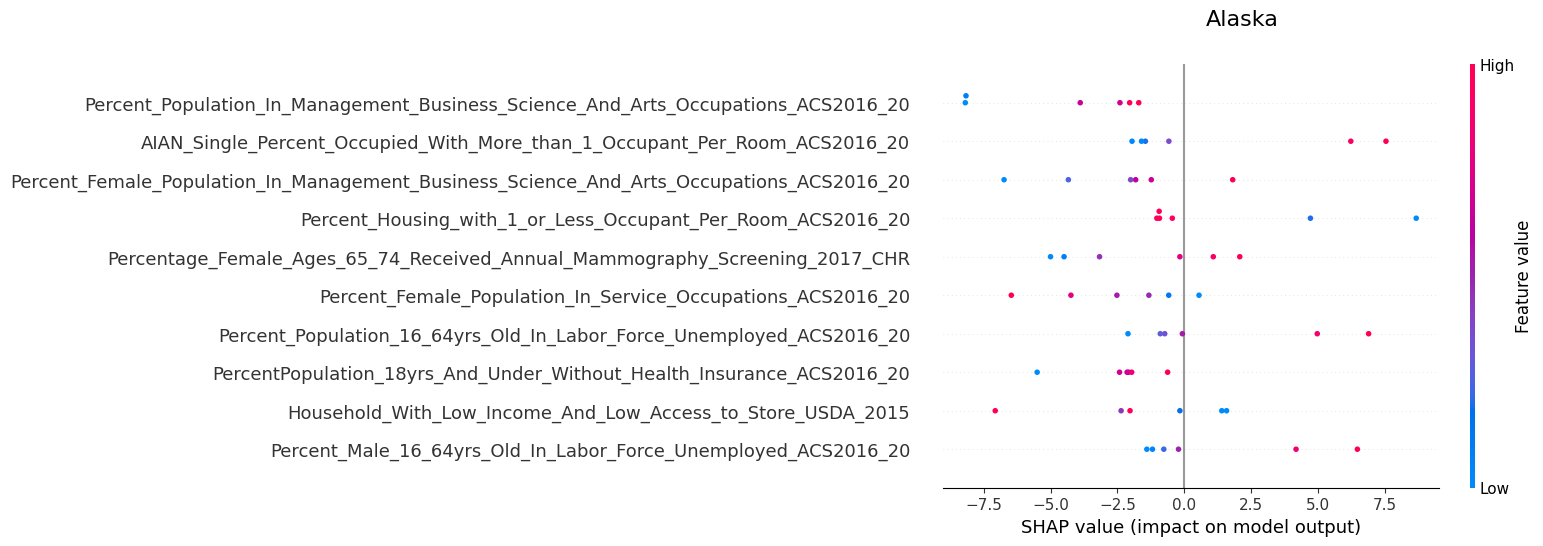

In [30]:
import shap
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X_test, max_display=10, show=False)
plt.gcf().suptitle("Alaska", fontsize=16)
plt.show()

